In [49]:
from sklearn import svm, metrics, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense,Activation,Dropout, MaxPooling1D, Conv1D, Flatten, BatchNormalization
# from tensorflow.keras.layers.normalization import BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import snappy
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [50]:
mask_file = r'\water_veg_mask'
mask_path = r'F:\workspace\jupyterNotebooks\Remote Sensing\ISRO\data'

In [51]:
water_veg_mask = np.load(r'.\data\water_veg_mask.npy')

In [52]:
unique, counts = np.unique(water_veg_mask, return_counts=True)
print(unique, counts)
water_veg_mask = water_veg_mask.flatten()

[0 1 2] [505368  14724 136008]


In [53]:
product_path = r'F:\SNAP\POSTINGARSS\final_S2A_MSIL2A_20190104T051211_N0211_R019_T43PGQ_20190104T094623_resampled.dim'

In [54]:
product = snappy.ProductIO.readProduct(product_path)
width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()

In [55]:
B2 = product.getBand('B2')
B3 = product.getBand('B3')
B4 = product.getBand('B4')
B5 = product.getBand('B5')
B6 = product.getBand('B6')
B7 = product.getBand('B7')
B8 = product.getBand('B8')
B8A = product.getBand('B8A')
B11 = product.getBand('B11')
B12 = product.getBand('B12')

In [56]:
B2_pixels = np.zeros(width * height, np.float32)
B2.readPixels(0,0,width,height,B2_pixels)
# B2_pixels.flatten()

B3_pixels = np.zeros(width * height, np.float32)
B3.readPixels(0,0,width,height,B3_pixels)
# B3_pixels.flatten()

B4_pixels = np.zeros(width * height, np.float32)
B4.readPixels(0,0,width,height,B4_pixels)
# B4_pixels.flatten()

B5_pixels = np.zeros(width * height, np.float32)
B5.readPixels(0,0,width,height,B5_pixels)

B6_pixels = np.zeros(width * height, np.float32)
B6.readPixels(0,0,width,height,B6_pixels)

B7_pixels = np.zeros(width * height, np.float32)
B7.readPixels(0,0,width,height,B7_pixels)

B8_pixels = np.zeros(width * height, np.float32)
B8.readPixels(0,0,width,height,B8_pixels)
# B8_pixels.flatten()

B8A_pixels = np.zeros(width * height, np.float32)
B8A.readPixels(0,0,width,height,B8A_pixels)

B11_pixels = np.zeros(width * height, np.float32)
B11.readPixels(0,0,width,height,B11_pixels)

B12_pixels = np.zeros(width * height, np.float32)
B12.readPixels(0,0,width,height,B12_pixels)

array([0.1364, 0.1364, 0.1508, ..., 0.2083, 0.2051, 0.2051], dtype=float32)

In [57]:
df = pd.DataFrame({'B2':B2_pixels, 
                   'B3': B3_pixels,
                   'B4': B4_pixels,
                   'B5': B5_pixels,
                   'B6': B6_pixels,
                   'B7': B7_pixels,
                   'B8': B8_pixels,
                   'B8A': B8A_pixels,
                   'B11': B11_pixels,
                   'B12': B12_pixels,
                    'Y':water_veg_mask})

In [58]:
df.head()

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,Y
0,0.0902,0.0584,0.0475,0.0797,0.1435,0.2031,0.2136,0.2323,0.1830,0.1364,2
1,0.0929,0.0895,0.0861,0.0797,0.1435,0.2031,0.2517,0.2323,0.1830,0.1364,2
2,0.0511,0.0699,0.0750,0.1231,0.1893,0.1987,0.2202,0.2181,0.1993,0.1508,0
3,0.0354,0.0611,0.0641,0.1231,0.1893,0.1987,0.1861,0.2181,0.1993,0.1508,0
4,0.0738,0.1050,0.1272,0.1664,0.2092,0.2346,0.2534,0.2576,0.2749,0.2159,0


In [59]:
x_cols = ['B2','B3','B4','B5','B6','B7', 'B8','B8A','B11','B12']

In [60]:
X = df[x_cols]
y = df['Y']

In [61]:
pca = PCA(n_components=4)
# X = StandardScaler().fit_transform(X)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4'])
finalDf = pd.concat([principalDf, df[['Y']]], axis = 1)

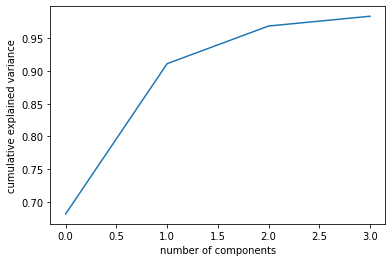

In [62]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [63]:
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,Y
0,-0.109932,-0.062318,-0.001755,0.026993,2
1,-0.076209,-0.052451,0.033014,0.056971,2
2,-0.070954,-0.045459,-0.014566,0.000864,0
3,-0.091869,-0.043123,-0.035429,-0.023107,0
4,0.064817,-0.009337,-0.037988,0.010353,0


In [64]:
X_train,X_test_val,y_train,y_test_val = train_test_split(finalDf[['principal component 1', 'principal component 2','principal component 3','principal component 4']],finalDf['Y'],test_size=0.4,random_state=1234, stratify = finalDf['Y'])

In [65]:
X_test,X_val, y_test, y_val = train_test_split(X_test_val,y_test_val,test_size=0.5,random_state=4321, stratify = y_test_val)

In [66]:
def show_confusion_matrix(y_test, y_pred, score):    
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    return cm

In [67]:
es = EarlyStopping(
    monitor='val_loss', 
    patience=50, 
    min_delta=0.001, 
    restore_best_weights=True
)

In [68]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
lr_pred1 = logisticRegr.predict(X_test)
lr_score = logisticRegr.score(X_test, y_test)
print(f"Testing accuracy of Logistic Regression = {lr_score}")
lr_pred2 = logisticRegr.predict(X_val)
lr_val_score = logisticRegr.score(X_val, y_val)
print(f"Validation accuracy of Logistic Regression = {lr_val_score}")

F:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy of Logistic Regression = 0.9497256515775034
Validation accuracy of Logistic Regression = 0.9491769547325103


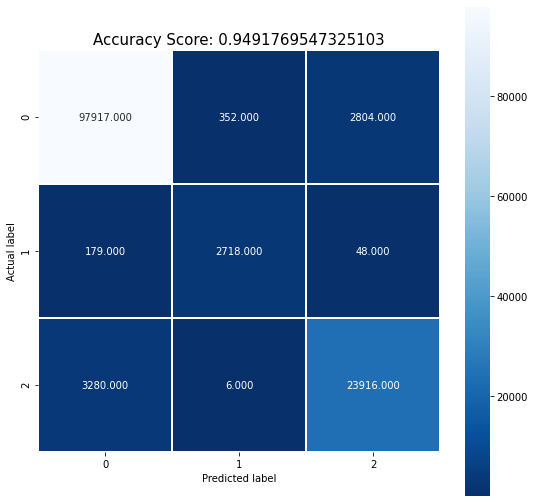

In [69]:
cm = show_confusion_matrix(y_test = y_val, y_pred = lr_pred2, score = lr_val_score)

F:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Kernel: rbf
Testing Accuracy SVM: 0.9557460752934004
validation Accuracy SVM: 0.955204999237921


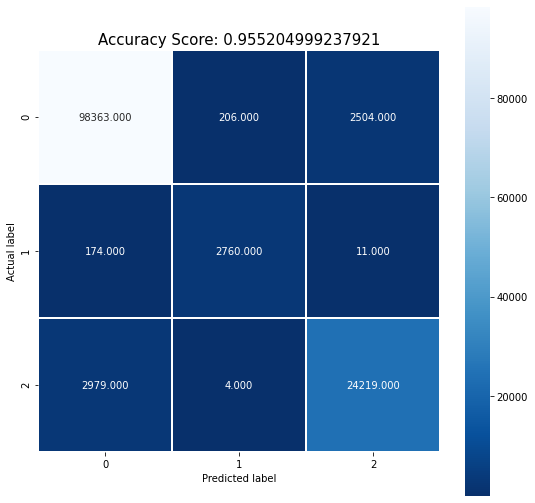

In [70]:
kernels = ['rbf']
for kernel in kernels:
    clf = svm.SVC(kernel = kernel, C = 100000 )
    clf.fit(X_train, y_train)
    svm_y_pred1 = clf.predict(X_test)
    print("Kernel:",kernel)
    svm_y_test_acc = metrics.accuracy_score(y_test, svm_y_pred1)
    print("Testing Accuracy SVM:",svm_y_test_acc)
    svm_y_pred_val = clf.predict(X_val)
    svm_y_val_acc = metrics.accuracy_score(y_val, svm_y_pred_val)
    print("validation Accuracy SVM:",svm_y_val_acc)
    cm = show_confusion_matrix(y_test = y_val, y_pred = svm_y_pred_val, score = svm_y_val_acc)

Testing Gaussian Naive Bayes Accuracy: 0.9295686633135193
Validation Accuracy GNB: 0.9291952446273434


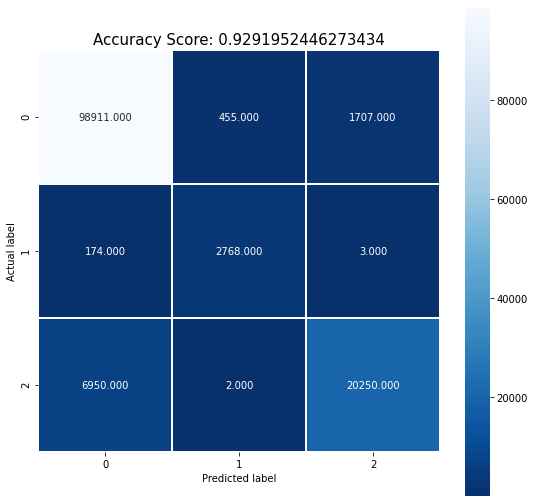

In [71]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_y_pred = gnb.predict(X_test)
gnb_y_val = gnb.predict(X_val)
gnb_y_test_acc = metrics.accuracy_score(y_test, gnb_y_pred)
gnb_y_val_acc = metrics.accuracy_score(y_val, gnb_y_val)
print("Testing Gaussian Naive Bayes Accuracy:",gnb_y_test_acc)
print(f"Validation Accuracy GNB: {gnb_y_val_acc}")
cm = show_confusion_matrix(y_test = y_val, y_pred = gnb_y_val, score = gnb_y_val_acc)

Testing Accuracy of Random Forest classifier for 100 estimators = 0.9578722755677488
Validation Accuracy of Random Forest classifier for 100 estimators = 0.9574912360920591


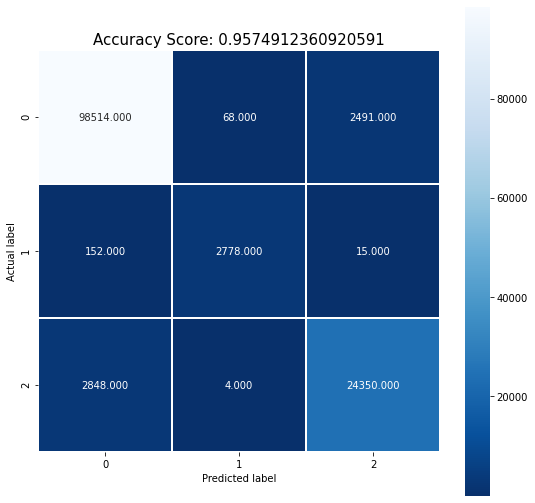

In [72]:
est = 100
rfc = RandomForestClassifier(n_estimators = est)
rfc.fit(X_train, y_train) 
rfc_y_pred = rfc.predict(X_test) 
rfc_y_val = rfc.predict(X_val)
rfc_y_test_acc = metrics.accuracy_score(y_test, rfc_y_pred)
rfc_y_val_acc = metrics.accuracy_score(y_val, rfc_y_val)
print(f"Testing Accuracy of Random Forest classifier for {est} estimators = {rfc_y_test_acc}")
print(f"Validation Accuracy of Random Forest classifier for {est} estimators = {rfc_y_val_acc}")
cm = show_confusion_matrix(y_test = y_val, y_pred = rfc_y_val, score = rfc_y_val_acc)

Testing Accuracy of 7 Nearest Neighbour classifier = 0.9563481176649901
Validation Accuracy of 7 Nearest Neighbour classifier = 0.9561575979271453


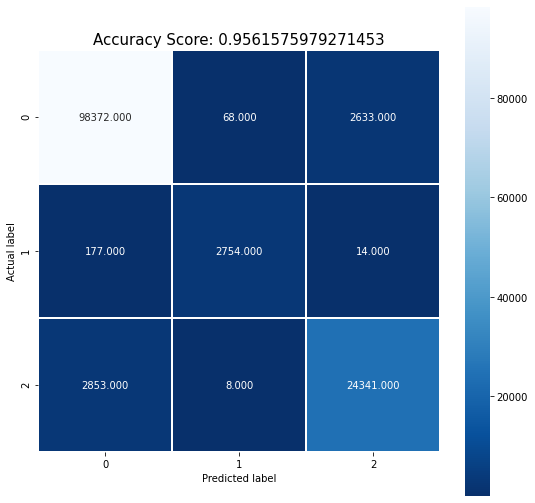

In [73]:
k = 7
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
knn_y_val = knn.predict(X_val)
knn_y_test_acc = metrics.accuracy_score(y_test, knn_y_pred)
knn_y_val_acc = metrics.accuracy_score(y_val, knn_y_val)
print(f"Testing Accuracy of {k} Nearest Neighbour classifier = {knn_y_test_acc}")
print(f"Validation Accuracy of {k} Nearest Neighbour classifier = {knn_y_val_acc}")
cm = show_confusion_matrix(y_test = y_val, y_pred = knn_y_val, score = knn_y_val_acc)

Testing Accuracy of Decision Tree classifier = 0.941617131534827
Validation Accuracy of Decision Tree classifier = 0.9410836762688615


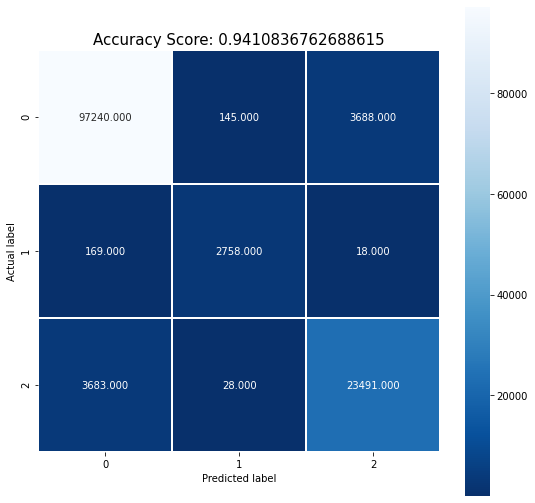

In [74]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_y_pred = dtc.predict(X_test)
dtc_y_val = dtc.predict(X_val)
dtc_y_test_acc = metrics.accuracy_score(y_test, dtc_y_pred)
dtc_y_val_acc = metrics.accuracy_score(y_val, dtc_y_val)
print(f"Testing Accuracy of Decision Tree classifier = {dtc_y_test_acc}")
print(f"Validation Accuracy of Decision Tree classifier = {dtc_y_val_acc}")
cm = show_confusion_matrix(y_test = y_val, y_pred = dtc_y_val, score = dtc_y_val_acc)

F:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Testing Accuracy of Stochastic Gradient Descent classifier| loss = modified_huber | penalty = l1| max iterations = 25|= 0.9534674592287761
Validation Accuracy of Stochastic Gradient Descent classifier| loss = modified_huber | penalty = l1| max iterations = 25|= 0.9530406950160036


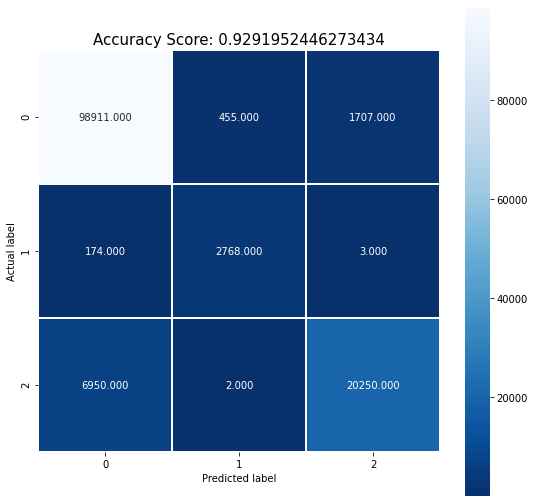

In [75]:
loss = "modified_huber"
penalty = "l1"
max_iterations = 25
sgdc = SGDClassifier(loss=loss, penalty=penalty, max_iter=max_iterations)
sgdc.fit(X_train, y_train)
sgdc_y_pred = sgdc.predict(X_test)
sgdc_y_val = sgdc.predict(X_val)
sgdc_y_test_acc = metrics.accuracy_score(y_test, sgdc_y_pred)
sgdc_y_val_acc = metrics.accuracy_score(y_val, sgdc_y_val)
print(f"Testing Accuracy of Stochastic Gradient Descent classifier| loss = {loss} | penalty = {penalty}| max iterations = {max_iterations}|= {sgdc_y_test_acc}")
print(f"Validation Accuracy of Stochastic Gradient Descent classifier| loss = {loss} | penalty = {penalty}| max iterations = {max_iterations}|= {sgdc_y_val_acc}")
cm = show_confusion_matrix(y_test = y_val, y_pred = sgdc_y_val, score = sgdc_y_val_acc)

F:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Testing Accuracy of XGBoost classifier = 95.85429050449626
Validation Accuracy of XGBoost classifier = 95.80018289894832


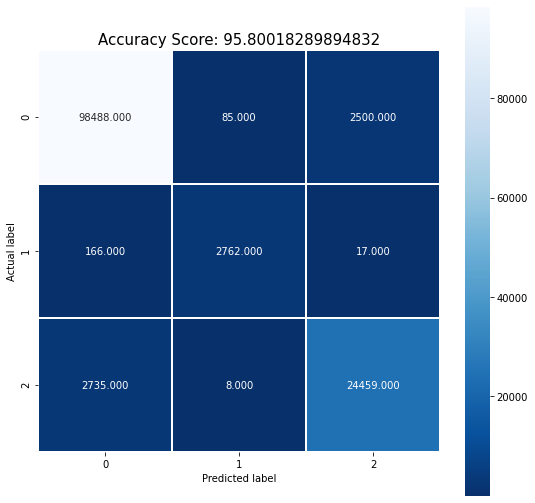

In [76]:
xgbc = XGBClassifier() 
xgbc.fit(X_train, y_train)
xgbc_y_pred = xgbc.predict(X_test) 
xgbc_y_val = xgbc.predict(X_val) 
xgbc_predictions = [round(value) for value in xgbc_y_pred]
xgbc_validations = [round(value) for value in xgbc_y_val]
xgbc_accuracy_test = accuracy_score(y_test, xgbc_predictions) * 100.0
xgbc_accuracy_val = accuracy_score(y_val, xgbc_validations) * 100.0
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"Testing Accuracy of XGBoost classifier = {xgbc_accuracy_test}")
print(f"Validation Accuracy of XGBoost classifier = {xgbc_accuracy_val}")
cm = show_confusion_matrix(y_test = y_val, y_pred = xgbc_validations, score = xgbc_accuracy_val)

In [77]:
y_train= to_categorical(y_train,num_classes=3)
y_test= to_categorical(y_test,num_classes=3)
y_val = to_categorical(y_val,num_classes=3)
print("Shape of y_train",y_train.shape)
print("Shape of y_test",y_test.shape)
print("Shape of y_val",y_val.shape)

Shape of y_train (393660, 3)
Shape of y_test (131220, 3)
Shape of y_val (131220, 3)


In [78]:
inputs = keras.Input(shape=(4,))
dense_1 = layers.Dense(32, activation="elu")
dense_2 = layers.Dense(32, activation="selu")
dense_3 = layers.Dense(32, activation="relu")
# dropout = layers.Dropout(0.4)
x = dense_1(inputs)
y = dense_2(inputs)
z = dense_3(inputs)
# x = layers.Dropout(0.4)(x)
x_skip = x
x = layers.Dropout(0.25)(x)
x = layers.Dense(32, activation="elu")(x)
x = keras.layers.add([x,x_skip])

y_skip = y
y = layers.Dropout(0.25)(y)
y = layers.Dense(32, activation="selu")(y)
y = keras.layers.add([y,y_skip])

z_skip = z
z = layers.Dropout(0.25)(z)
z = layers.Dense(32, activation="relu")(z)
z = keras.layers.add([z, z_skip])

    # x = layers.Dropout(0.4)(x)

x_skip = x
x = layers.Dropout(0.25)(x)
x = layers.Dense(32, activation="elu")(x)
x = keras.layers.add([x,x_skip])

y_skip = y
y = layers.Dropout(0.25)(y)
y = layers.Dense(32, activation="selu")(y)
y = keras.layers.add([y,y_skip])

z_skip = z
z = layers.Dropout(0.25)(z)
z = layers.Dense(32, activation="relu")(z)
z = keras.layers.add([z, z_skip])


merge_1 = keras.layers.add([x,y])
merge_2 = keras.layers.add([y,z])
# x = layers.Dropout(0.4)(x)
outputs = layers.Dense(3, activation="softmax")(keras.layers.add([merge_1,merge_2]))
pca_model_keras = keras.Model(inputs=inputs, outputs=outputs, name="pca_model")
    
print(pca_model_keras.summary())
    
model_png = keras.utils.plot_model(
        pca_model_keras,
        to_file=r'.\data\pca_model_residual.png',
        show_shapes=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
)
    
pca_model_keras.compile(
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"],
)

Model: "pca_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 32)           160         input_4[0][0]                    
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 32)           160         input_4[0][0]                    
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 32)           160         input_4[0][0]                    
__________________________________________________________________________________________

In [79]:
history_keras = pca_model_keras.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=64,epochs=200,verbose=1, callbacks = [es])

Train on 393660 samples, validate on 131220 samples
Epoch 1/200
393660/393660 [==============================] - 32s 81us/sample - loss: 0.1192 - accuracy: 0.9497 - val_loss: 0.1054 - val_accuracy: 0.9549
Epoch 2/200
393660/393660 [==============================] - 31s 79us/sample - loss: 0.1094 - accuracy: 0.9540 - val_loss: 0.1041 - val_accuracy: 0.9556
Epoch 3/200
393660/393660 [==============================] - 31s 79us/sample - loss: 0.1077 - accuracy: 0.9545 - val_loss: 0.1039 - val_accuracy: 0.9558
Epoch 4/200
393660/393660 [==============================] - 31s 80us/sample - loss: 0.1065 - accuracy: 0.9548 - val_loss: 0.1061 - val_accuracy: 0.9547
Epoch 5/200
393660/393660 [==============================] - 31s 80us/sample - loss: 0.1055 - accuracy: 0.9552 - val_loss: 0.1012 - val_accuracy: 0.9564
Epoch 6/200
393660/393660 [==============================] - 31s 80us/sample - loss: 0.1052 - accuracy: 0.9554 - val_loss: 0.1011 - val_accuracy: 0.9563
Epoch 7/200
393660/393660 [===

Epoch 54/200
393660/393660 [==============================] - 31s 78us/sample - loss: 0.1001 - accuracy: 0.9569 - val_loss: 0.0990 - val_accuracy: 0.9574
Epoch 55/200
393660/393660 [==============================] - 31s 79us/sample - loss: 0.1002 - accuracy: 0.9568 - val_loss: 0.0981 - val_accuracy: 0.9578
Epoch 56/200
393660/393660 [==============================] - 31s 78us/sample - loss: 0.1002 - accuracy: 0.9570 - val_loss: 0.0990 - val_accuracy: 0.9573
Epoch 57/200
393660/393660 [==============================] - 31s 78us/sample - loss: 0.1000 - accuracy: 0.9569 - val_loss: 0.0985 - val_accuracy: 0.9578
Epoch 58/200
393660/393660 [==============================] - 31s 78us/sample - loss: 0.1001 - accuracy: 0.9569 - val_loss: 0.0982 - val_accuracy: 0.9578
Epoch 59/200
393660/393660 [==============================] - 31s 78us/sample - loss: 0.1002 - accuracy: 0.9570 - val_loss: 0.0994 - val_accuracy: 0.9574
Epoch 60/200
393660/393660 [==============================] - 31s 78us/sampl

Validation Accuracy of Neural Network on PCA data 95.6866331351928


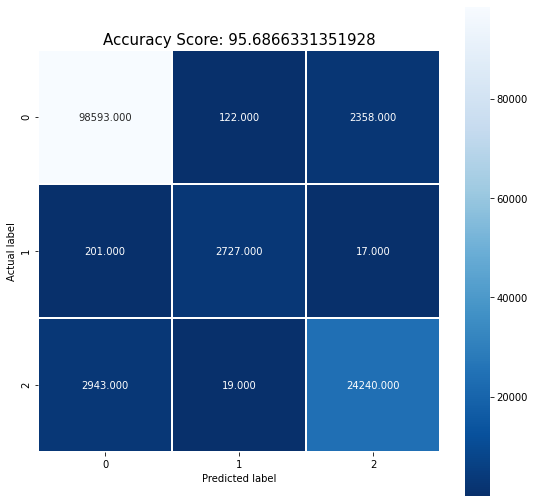

In [80]:
pca_prediction_keras = pca_model_keras.predict(X_val)
length=len(pca_prediction_keras)
pca_y_label=np.argmax(y_val,axis=1)
pca_predict_label_keras=np.argmax(pca_prediction_keras,axis=1)

pca_accuracy_keras=np.sum(pca_y_label==pca_predict_label_keras)/length * 100 
print("Validation Accuracy of Neural Network on PCA data",pca_accuracy_keras )
cm = show_confusion_matrix(y_test = pca_y_label, y_pred = pca_predict_label_keras, score = pca_accuracy_keras)